# Calculate Coverage

You have a large region of interest. You need to identify an AOI for your study. One of the inputs to that decision is the coverage within the region. This notebook will walk you through that process.

In this notebook, we create the coverage map for `PSOrthotiles` collected in 2017 through August for the state of Iowa. While we perform this demonstration only in a small region of Iowa (due to data coverage restrictions of some users), we show results for the entire state.  The coverage calculation is performed in WGS84 because the state of Iowa covers a larger area than a single UTM zone.

In [1]:
import copy
import datetime
import json
import os

from IPython.display import display
import matplotlib
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from planet import api
from planet.api import filters
import rasterio
from rasterio import features as rfeatures
from shapely import geometry as sgeom

%matplotlib inline

## Define AOI

Define the AOI as a geojson polygon. This can be done at [geojson.io](http://geojson.io). If you use geojson.io, only copy the single aoi feature, not the entire feature collection.

In [2]:
aoi = {
    "type": "Feature",
    "geometry": {
        "type": "Polygon",
        "coordinates": [
            [
                [-93.299129, 42.699599],
                [-93.299674, 42.812757],
                [-93.288436, 42.861921],
                [-93.265332, 42.924817],
                [-92.993873, 42.925124],
                [-92.993888, 42.773637],
                [-92.998396, 42.754529],
                [-93.019154, 42.699988],
                [-93.299129, 42.699599]
            ]
        ]
    },
    "properties": {
        "name": "iowa_crops"
    }
}

In [3]:
# This is a larger aoi so will demonstrate coverage over a larger area
# However, it is the entire state of iowa, so is too large to include in the devrel
# demo data coverage.
# with open('iowa.geojson', 'r') as src:
#     aoi = json.load(src)

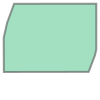

In [4]:
# this notebook uses rasterio Shapes for processing, so lets convert that geojson to a shape
aoi_shape = sgeom.shape(aoi['geometry'])
aoi_shape

## Build Request

Build the Planet API Filter request.

Customize this code for your own purposes

In [5]:
DATE_START = datetime.datetime(year=2017,month=1,day=1)
DATE_END = datetime.datetime(year=2017,month=9,day=1)

def build_request(aoi_shape, date_start=DATE_START, date_end=DATE_END, addl_filters=None):
    base_filters = [
        filters.geom_filter(sgeom.mapping(aoi_shape)),
        filters.range_filter('cloud_cover', lt=.1),
        filters.date_range('acquired', gt=date_start),
        filters.date_range('acquired', lt=date_end),
    ]
    
    if addl_filters is not None:
        base_filters += addl_filters

    query = filters.and_filter(*base_filters)
    
    item_types = ['PSOrthoTile']
    return filters.build_search_request(query, item_types)

request = build_request(aoi_shape)
# print(request)

## Set Coverage Grid Dimensions

Set the grid dimensions according to the AOI shape and the resolution of interest

In [6]:
dimensions = (3000, 4000)

## Search Planet API

The client is how we interact with the planet api. It is created with the user-specific api key, which is pulled from $PL_API_KEY environment variable.

In [7]:
# if your Planet API Key is not set as an environment variable, you can paste it below
API_KEY = os.environ.get('PL_API_KEY', 'PASTE_YOUR_KEY_HERE')

client = api.ClientV1(api_key=API_KEY)

In [8]:
def search_pl_api(request, client, limit=500):
    result = client.quick_search(request)
    
    # note that this returns a generator
    return result.items_iter(limit=limit)

item = next(search_pl_api(build_request(aoi_shape), client, limit=1))
print(json.dumps(item['properties'], indent=4))

{
    "acquired": "2017-01-01T16:17:15.619269Z",
    "anomalous_pixels": 0,
    "black_fill": 0.1,
    "cloud_cover": 0.002,
    "columns": 8000,
    "epsg_code": 32615,
    "grid_cell": "1558814",
    "ground_control": true,
    "gsd": 4.1,
    "item_type": "PSOrthoTile",
    "origin_x": 475500,
    "origin_y": 4752500,
    "pixel_resolution": 3.125,
    "provider": "planetscope",
    "published": "2018-06-12T23:18:02.000Z",
    "rows": 8000,
    "satellite_id": "0e14",
    "strip_id": "345009",
    "sun_azimuth": 151.1,
    "sun_elevation": 18.7,
    "updated": "2018-06-12T23:18:02.000Z",
    "usable_data": 0.9,
    "view_angle": 0.8
}


## Calculate Coverage

First query the planet api for the items that match the request defined above, then calculate the overlap between each item and the aoi. Finally, convert each overlap to a grid using [`rasterio.rasterize`](https://mapbox.github.io/rasterio/topics/features.html#burning-shapes-into-a-raster), accumulate coverage over the overlap grids, and display the coverage grid.

In [9]:
def calculate_overlap(item, aoi_shape):
    footprint_shape = sgeom.shape(item['geometry'])
    return aoi_shape.intersection(footprint_shape)

def calculate_overlaps(items, aoi_shape):
    item_num = 0
    overlap_num = 0
    for i in items:
        item_num += 1
        overlap = calculate_overlap(i, aoi_shape)
        if not overlap.is_empty:
            overlap_num += 1
            yield overlap
    print('{} overlaps from {} items'.format(overlap_num, item_num))

In [10]:
def calculate_coverage(overlaps, dimensions, bounds):
    
    # get dimensions of coverage raster
    mminx, mminy, mmaxx, mmaxy = bounds

    y_count, x_count = dimensions
    
    # determine pixel width and height for transform
    width = (mmaxx - mminx) / x_count
    height = (mminy - mmaxy) / y_count # should be negative

    # Affine(a, b, c, d, e, f) where:
    # a = width of a pixel
    # b = row rotation (typically zero)
    # c = x-coordinate of the upper-left corner of the upper-left pixel
    # d = column rotation (typically zero)
    # e = height of a pixel (typically negative)
    # f = y-coordinate of the of the upper-left corner of the upper-left pixel
    # ref: http://www.perrygeo.com/python-affine-transforms.html
    transform = rasterio.Affine(width, 0, mminx, 0, height, mmaxy)
    
    coverage = np.zeros(dimensions, dtype=np.uint16)
    for overlap in overlaps:
        if not overlap.is_empty:
            # rasterize overlap vector, transforming to coverage raster
            # pixels inside overlap have a value of 1, others have a value of 0
            overlap_raster = rfeatures.rasterize(
                    [sgeom.mapping(overlap)],
                    fill=0,
                    default_value=1,
                    out_shape=dimensions,
                    transform=transform)
            
            # add overlap raster to coverage raster
            coverage += overlap_raster
    return coverage

In [11]:
items = search_pl_api(build_request(aoi_shape), client, limit=10000)
overlaps = calculate_overlaps(items, aoi_shape)

# cache coverage calculation because it takes a little while to create
coverage = calculate_coverage(overlaps, dimensions, aoi_shape.bounds)

682 overlaps from 682 items


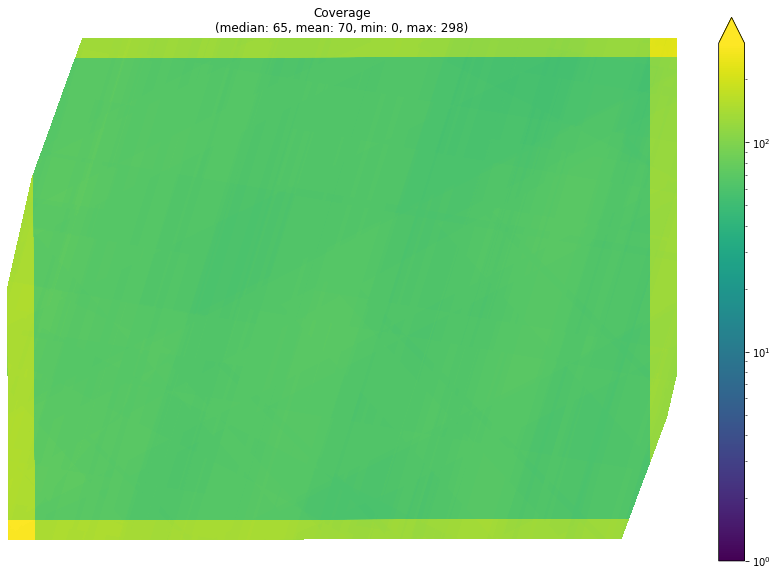

In [12]:
def plot_coverage(coverage):
    fig, ax = plt.subplots(figsize=(15,10))
    
    # ref: https://matplotlib.org/users/colormapnorms.html
    pcm = ax.imshow(coverage,
                       interpolation='nearest',
                       norm=colors.LogNorm(vmin=max(1, coverage.min()), # avoid divide by zero
                                           vmax=coverage.max()),
                       cmap=cm.viridis)
    fig.colorbar(pcm, ax=ax, extend='max')
    fig.show()

    ax.set_title('Coverage\n(median: {}, mean: {}, min: {}, max: {})'.format(
        int(np.median(coverage)),
        int(np.mean(coverage)),
        int(np.min(coverage)),
        int(np.max(coverage))
    ))
    ax.axis('off')
    
    # uncomment to save image of coverage for the entire state of iowa
#     plt.savefig('iowa_state.png')

plot_coverage(coverage)

Median coverage is 65 for the `iowa_crops` aoi, which is great for the number of satellites we had in 2017. The coverage is much greater now but we are interested in 2017 because we have some crop census data from that year. This aoi is essentially the footprint of a single PSOrthotile, so there isn't much variation in coverage. The strips of higher coverage are due to overlap that has been designed into the `PSOrthotile` gridding system.

For more variation in coverage (and to determine where we would want to locate our study within Iowa for greatest coverage), we can look at the coverage map for the entire state of Iowa.

![Iowa State Coverage](iowa_state.png "Iowa State Coverage")

Coverage across the entire state is pretty good so all of the state would be a good candidate for our study. The south-eastern corner of the state has the least coverage, while the western edge of the state has the best.